# Algorithm step-by-step visual explanation

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from daugman import daugman

import itertools
import random

from typing import List, Tuple

## Functions

In [2]:
plt.rcParams['figure.figsize'] = [5, 5]

In [3]:
import math

def get_intensities(gray_img: np.ndarray, center: Tuple[int, int],
            start_r: int, end_r: int, step: int = 1) -> Tuple[float, int]:
    """ Part of ``daugman()`` modified for presentation purposes
    """
    x, y = center
    intensities = []
    mask = np.zeros_like(gray_img)
    
    # for every radius in range
    radii = list(range(start_r, end_r, step))
    for r in radii:
        # draw circle on mask
        cv2.circle(mask, center, r, 255, 1)
        # get pixel from original image, it is faster than np or cv2
        diff = gray_img & mask
        # normalize, np.add.reduce faster than .sum()
        #            diff[diff > 0] faster than .flatten()
        intensities.append(np.add.reduce(diff[diff > 0]) / (2 * math.pi * r))
        # refresh mask
        mask.fill(0)

    # calculate delta of radius intensitiveness
    intensities_np = np.array(intensities, dtype=np.float32)
   
    return intensities_np, radii

In [4]:
def draw_circles(img: np.ndarray,
                 center: Tuple[int, int], color:[int, int, int],
                 start_r: int, end_r: int, step: int,
                 alpha=0.5) -> np.ndarray:
    """ Part of ``daugman()`` modified for presentation purposes
    """
    # get separate coordinates
    x, y = center    
    overlay = img.copy()
    
    radii = list(range(start_r, end_r, step))
    for r in radii:
        cv2.circle(overlay, center, r, color, 1)
        
    img = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
    
    return img

In [5]:
def find_max_circles(gray: np.ndarray,
                     all_points: List[Tuple[int, int]],
                     start_r: int, end_r: int, step: int) -> (list, list):
    """ The bottom part of ``find_iris()``, but it returns the best candidates
        for each point instead of the final answer
    """
    values = []
    coords = []
    
    for point in all_points:
        val, r = daugman(gray, point, start_r, end_r, step)
        values.append(val)
        coords.append([point, r])

    return coords, values

In [6]:
def get_new_image(img_path='eye.jpg', gray=False) -> np.ndarray:
    """ Get properly cropped BGR image, which looks like grayscale
    """
    img = cv2.imread(img_path)
    img = img[20:130, 20:130]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if not gray:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img

## Explanation

### Not exactly Daugman's part

Daugman is pretty expensive to compute if we will do that for every pixel in the image.

Thus, we will imply, that the iris cannot be larger than 1/3 of the image side, if eye is properly cropped.

So, we do not have to check every pixel on the image, only those, which are in the central 1/3 of image:

```
0 0 0
0 1 0
0 0 0
```

Also we will take only every 3rd point.

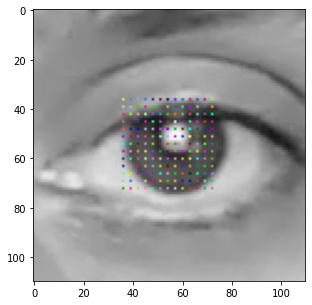

In [23]:
# load image
img = get_new_image()

# get all potential points for search (from `find_iris()`)
h = img.shape[0]
# we will look only on dots within central 1/3 of image
single_axis_range = range(int(h / 3), h - int(h / 3), 3)
all_points = list(itertools.product(single_axis_range, single_axis_range))

# get different color for each potential point
random.seed(2020)
colors = [[random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)] for i in all_points]

# plot all potential points
img_dot = img.copy()
for point, color in zip(all_points, colors):
    cv2.circle(img_dot, point, 0, color, -1)
_ = plt.imshow(img_dot[::,::,::-1])

Now, for each point we will run the Daugman's algorithm

### The Daugman's part

Also we presume, that iris could not be less than a circle with a certain radius, let's say 10px.

Now for each circle between min and max radius with the step 1px, we will take all pixel values and sum them up.

For visibility we will plot only every second circle.

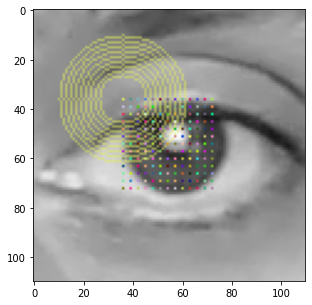

In [24]:
img_circles = img_dot.copy()

# we will look on a single potential point
idx = 0
# within circles in radii range from 10px to 1/4 of image side
start_r = 10
end_r = int(img.shape[0] / 4)

# plot the chosen potential point
cv2.circle(img_circles, list(all_points)[idx], 0, colors[idx], 1)
# plot all circle candidates for the single potential point
img_circles = draw_circles(img_circles, all_points[idx], colors[idx],
                           start_r=start_r, end_r=end_r, step=2)

_ = plt.imshow(img_circles[::,::,::-1])

The idea is to find the biggest drop in intensivety values between two neighbor circles.

It should imply the transaction between iris and it's surroundings.

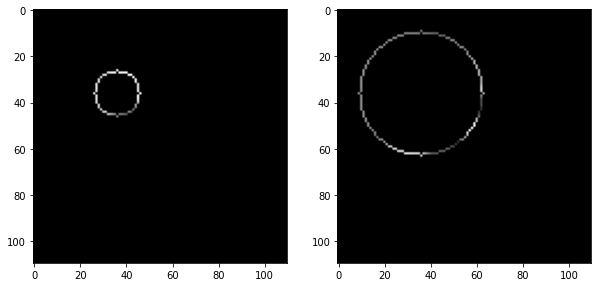

In [25]:
img = get_new_image(gray=True)
mask_s = np.zeros_like(img)
mask_e = np.zeros_like(img)
# draw circle on mask
cv2.circle(mask_s, all_points[idx], start_r, 255, 1)
cv2.circle(mask_e, all_points[idx], end_r, 255, 1)
# get pixel from original image, it is faster than np or cv2
diff_s = img & mask_s
diff_e = img & mask_e

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(diff_s, cmap='gray')
axs[1].imshow(diff_e, cmap='gray')

In [26]:
np.add.reduce(diff_s[diff_s > 0]) / (2 * math.pi * start_r)

123.77479924256701

In [27]:
np.add.reduce(diff_e[diff_e > 0]) / (2 * math.pi * end_r)

125.86798147560154

In [28]:
img = get_new_image(gray=True)
intensities, radii = get_intensities(img, all_points[idx],
                                     start_r=start_r, end_r=end_r, step=1)

In [45]:
# intensities.tolist()

In [44]:
# abs((intensities[1:] - intensities[:-1])).tolist()

In [42]:
max(abs(intensities[1:] - intensities[:-1]))

7.2878494


![delta](delta.png)

In [132]:
a = np.array([-10, 1, 1, 5, 8], dtype=np.float)
print(cv2.GaussianBlur(a, (1, 5), 0))
print(cv2.GaussianBlur(abs(a), (1, 5), 0))

[[-3.125]
 [-1.5  ]
 [ 1.75 ]
 [ 4.5  ]
 [ 5.625]]
[[4.375]
 [3.5  ]
 [3.   ]
 [4.5  ]
 [5.625]]


It does not matter either will you pass negative or positive values to Gaussian function, because it will be squared:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/dd16b16869269dba008d19c0969515a1d50b3ae2)

In [81]:
Z = [1, 4, 6, 4, 1,
     4, 16, 24, 16, 4,
     6, 24, 36, 24, 6,
     4, 16, 24, 16, 4,
     1, 4, 6, 4, 1]

In [128]:
Z = np.array(x).reshape(5, 5) / 256

<AxesSubplot:>

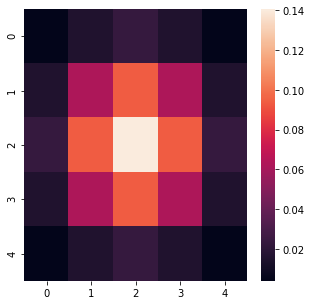

In [129]:
import seaborn as sns

sns.heatmap(Z)

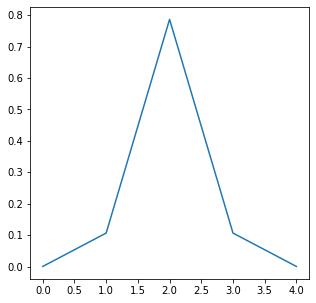

In [127]:
plt.plot([0.0003, 0.1065, 0.7866, 0.1065, 0.0003])

In [84]:
X, Y = np.meshgrid(range(1, 6), range(1, 6))

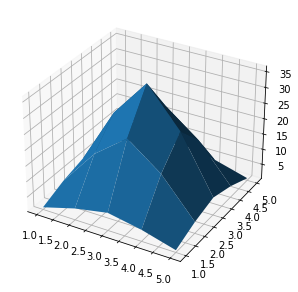

In [117]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1)
# ax.view_init(45, 35)

In [43]:
(cv2.GaussianBlur(abs(intensities[1:] - intensities[:-1]), (1, 5), 0))

array([[5.6983852],
       [4.666045 ],
       [3.2020159],
       [3.0471845],
       [3.1863585],
       [2.707961 ],
       [2.1194816],
       [1.7157626],
       [1.7933602],
       [2.2991376],
       [2.6713452],
       [2.5620112],
       [1.9527287],
       [1.6090088],
       [1.9296494],
       [2.1940422]], dtype=float32)

In [32]:
# get the best circle candidates for each point
coords, values = find_max_circles(img, all_points,
                                  start_r=start_r, end_r=end_r, step=1)

In [46]:
values[idx]

array([5.6983852], dtype=float32)

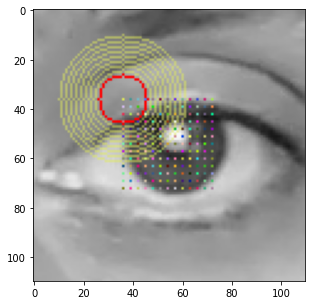

In [18]:
# get best circle candidate for the chosen potential point
point, r = coords[idx]
# plot it in red color
cv2.circle(img_circles, point, r, [0, 0, 255], 1)
_ = plt.imshow(img_circles[::,::,::-1])

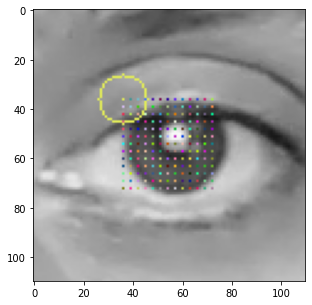

In [47]:
img = img_dot.copy()
cv2.circle(img, all_points[idx], 0, colors[idx], 1)
point, r = coords[idx]
cv2.circle(img, point, r, colors[idx], 1)
_ = plt.imshow(img[::,::,::-1])

We will do that for each potential point, so we will end up with 167 potential irises.

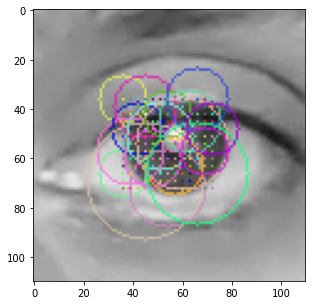

In [48]:
img = img_dot.copy()
overlay = img_dot.copy()
alpha = 0.8
for idx in range(0, len(coords), 10):
    cv2.circle(overlay, all_points[idx], 0, colors[idx], 1)
    point, r = coords[idx]
    cv2.circle(overlay, point, r, colors[idx], 1)
img = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
_ = plt.imshow(img[::,::,::-1])

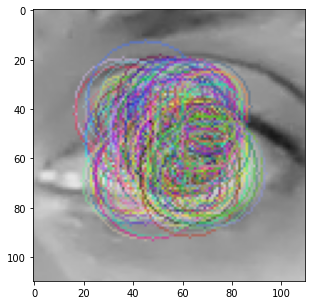

In [49]:
img = img_dot.copy()

for c, color in zip(coords, colors):
    overlay = img.copy()
    point, r = c
    cv2.circle(overlay, point, r, color, 1)
    alpha = 0.5
    img = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
    
_ = plt.imshow(img[::,::,::-1])

And we need only to take the circle with the highest drop in value, it will be our iris.

97
(57, 54) 20


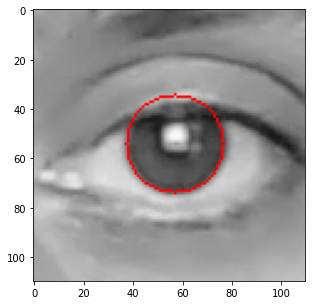

In [50]:
img = get_new_image()

point, r = coords[values.index(max(values))]
color = [0, 0, 255]
cv2.circle(img, point, r, color, 1)


print(values.index(max(values)))
print(point, r)
_ = plt.imshow(img[::,::,::-1])

Параметры можно тюнить и алгоритм можно использовать для детекта любых круглых объектов на контрастном фоне, который плохо бинаризируется